# Well Tempered Data

## Weather Analysis Visualization

### Part 1: Use `Dark Sky API` to get historical weather data

In [1]:
import os
import sys
from dotenv import load_dotenv

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

# add local python functions
sys.path.append(os.path.join(PROJ_ROOT, "src"))

# get darksky.io API KEY end other keys from `~/.env`
load_dotenv(os.path.join(os.path.expanduser('~'), ".env"))

True

Specify when notebook was run, and with which packages. Specially useful for nbview, blog posts, and other media where the notebook is not being shared as executable code.

In [2]:
%load_ext watermark
%watermark -a "J. Bruno Morgado" -d -t -v -p numpy,pandas,geopy -g

J. Bruno Morgado 2017-04-05 22:53:05 

CPython 3.5.3
IPython 5.3.0

numpy 1.12.1
pandas 0.19.2
geopy 1.11.0
Git hash: 73ed1f32306ec0a6d140c7f5141b238f24299523


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import json
from datetime import date, datetime

%matplotlib inline

## Get location and Timezone
- Use `geopy` to get the coordinates of the location.
- Use `geopy` to get the timezone of the location. This will be needed when importing the json API data into a Pandas dataframe.
- Alternatively we could use `tzwhere` to get the timezone offline.

In [4]:
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
location = geolocator.geocode("Porto, Portugal")
timezone = geolocator.timezone((location.latitude, location.longitude))
print(location.address)
print(location.latitude, location.longitude)
print(timezone)

Porto, Portugal
41.1579438 -8.629105299999999
Europe/Lisbon


## Get historical weather conditions
Use `darksky` API to get the weather data for the location.

The relevant documentation can be acessed at: https://darksky.net/dev/docs/time-machine

In [5]:
import requests

def get_weather(latitude, longitude, date, units='auto'):
    """ Takes a location and a day and returns the weather conditions.
    
        Parameters
        ----------
        :param latitude: Latitude in float
        :param longitude: Longitude in float
        :param date: Date for the observation as a datetime.date
        :param units: Units. Default auto. Possible values: auto, ca, uk2, us, si
        :returns: A JSON object with the dayly weather conditions
    """
    api_forecast_io = 'https://api.forecast.io/forecast/{}/{},{},{}?units={}'
    date = '{}T00:00:00'.format(date) 
    lookup_url = api_forecast_io.format(os.environ.get('DARKSKY_KEY'), latitude, longitude, date, units)
    
    return(requests.get(lookup_url).json())

Use the `get_weather` http **request** to get the weather observations for a specific date.

In [6]:
# get the weather observations for a specific day in the past
date = date(1978, 6, 14)
observations = get_weather(location.latitude, location.longitude, date)

We can now see what the daily data looks like.

More information about the **response** at: https://darksky.net/dev/docs/response

In [7]:
observations['daily']['data']

[{'apparentTemperatureMax': 19.51,
  'apparentTemperatureMaxTime': 266677200,
  'apparentTemperatureMin': 12.22,
  'apparentTemperatureMinTime': 266709600,
  'cloudCover': 0.82,
  'dewPoint': 11.92,
  'humidity': 0.82,
  'icon': 'clear-day',
  'moonPhase': 0.27,
  'precipType': 'rain',
  'pressure': 1013.69,
  'summary': 'Clear throughout the day.',
  'sunriseTime': 266648556,
  'sunsetTime': 266702986,
  'temperatureMax': 19.51,
  'temperatureMaxTime': 266677200,
  'temperatureMin': 12.22,
  'temperatureMinTime': 266709600,
  'time': 266626800,
  'visibility': 9.85,
  'windBearing': 357,
  'windSpeed': 0.8}]

## Process received data and plot it

- *normalize* the hourly data into a flat table in `pandas`.
- Convert the `time` field into a readable `datetime` format:
    - Localize the `datetime` in *UTC*.
    - Convert the `datetime` to the local `timezone`.
- Use the `time` as index.
- Plot the `temperature` for the hourly data.

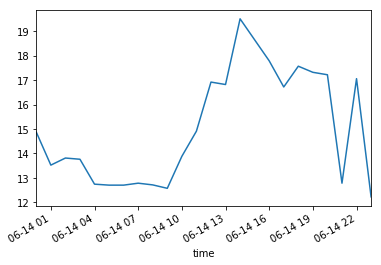

In [8]:
hourly_data = observations['hourly']['data']
hourly = pd.io.json.json_normalize(hourly_data)
hourly['time'] = pd.to_datetime(hourly['time'], unit='s', infer_datetime_format=True).dt.tz_localize('UTC').dt.tz_convert(timezone)
hourly.set_index('time', inplace=True)
hourly.temperature.plot()